<a href="https://colab.research.google.com/github/Arju-Jawla/Mean-Sea-Level-Anomalies/blob/main/MSLA_02_trend_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing Required Libraries

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.1 MB/s eta 0:00:00


In [ ]:
!pip install ctime

  Preparing metadata (setup.py) ... done
  Created wheel for ctime: filename=ctime-1.0.0-py3-none-any.whl size=2673 sha256=348cb1e96bf07cf42df41a9e1a800b9cfd7ad1d726fe94d3ae5c2e1ad02e7ce6
  Stored in directory: /root/.cache/pip/wheels/9e/e0/b5/931e02f22d8e9bdf979e6451e9d246a253e049638a9af7cc67
Successfully built ctime


In [ ]:
import numpy as np                           #numerical python library
import pandas as pd                          #data manipulation and analysis library

%matplotlib inline
import matplotlib.pyplot as plt              #plotting library

from netCDF4 import Dataset                  #reading netcdf files

import cftime                                #for time conversion
import datetime                              #for date manipulation
from datetime import datetime

In [ ]:
from sklearn.linear_model import LinearRegression

## 2. Loading Files

In [ ]:
#load nc file from google drive
ncfile = '/content/drive/MyDrive/Project Learnings/Data/dt_global_satellite_sla_199302_202305.nc'

In [ ]:
# Open the netCDF file specified by 'ncfile' in read-only mode ('r')
# and assign it to the file handle 'fh'
fh = Dataset(ncfile, mode = 'r')

## 3. Assigning variables

In [ ]:
#extracting the variable
sla = fh.variables['sla'][:]
lon  = fh.variables['longitude'][:]
lat  = fh.variables['latitude'][:]
time_var = fh.variables['time']

In [ ]:
print(sla.shape)

(364, 720, 1440)


In [ ]:
dates = cftime.num2date(time_var[:], units=time_var.units)
dates_converted = [datetime(d.year, d.month, d.day) for d in dates]

## 4. Getting Ports data

In [ ]:
# Define coordinates for each port (approximate)
# Each subregion will cover 1x1 degree around the port
ports = {
    "Vishakhapatnam": {"lat": 17.7, "lon": 83.3},
    "Kandla": {"lat": 23.0, "lon": 70.2},
    "Mumbai": {"lat": 19.0, "lon": 72.8},
    "Paradip": {"lat": 20.3, "lon": 86.6},
    "Cochin": {"lat": 9.9, "lon": 76.3}
}

In [ ]:
# Function to get index range for a specified grid point with 1x1 degree tolerance
def get_grid_indices(lat, lon, lat_values, lon_values, tolerance=0.5):
    lat_indices = np.where((lat_values >= lat - tolerance) & (lat_values <= lat + tolerance))[0]
    lon_indices = np.where((lon_values >= lon - tolerance) & (lon_values <= lon + tolerance))[0]
    return lat_indices, lon_indices

In [ ]:
# Loop through each port and extract data
subregion_data = {}                                          #creates empty dict
for port, coords in ports.items():
    lat_idx, lon_idx = get_grid_indices(coords["lat"], coords["lon"], lat, lon)

    # Extract temperature data for the subregion
    subregion_sla = sla[:, lat_idx[0]:lat_idx[-1] + 1, lon_idx[0]:lon_idx[-1] + 1]
    subregion_sla_mean = np.mean(subregion_sla, axis=(1, 2))  # Mean over spatial dimensions (lat, lon)

    # Store in dictionary
    subregion_data[port] = subregion_sla_mean

## 5. Prepare data to find trends

In [ ]:
# Create a DataFrame from the subregion data
data = pd.DataFrame(subregion_data)
data['Date'] = dates_converted
data.set_index('Date', inplace=True)

In [ ]:
data.head()

,Vishakhapatnam,Kandla,Mumbai,Paradip,Cochin
Date,,,,,
1993-02-15,-0.10529,0.00740,0.046175,-0.188589,0.072789
1993-03-15,-0.10116,-0.01496,0.027392,-0.253900,0.071356
1993-04-15,-0.05141,-0.02428,0.028483,-0.151467,0.063489
1993-05-15,-0.04368,-0.00176,0.002800,-0.030378,0.004533
1993-06-15,-0.01149,0.01566,-0.011658,0.062744,-0.026656


In [ ]:
data.describe()

,Vishakhapatnam,Kandla,Mumbai,Paradip,Cochin
count,364.000000,364.000000,364.000000,364.000000,364.000000
mean,0.045726,0.040645,0.057524,0.041606,0.049330
std,0.104241,0.069768,0.072504,0.127390,0.094383
min,-0.214940,-0.132000,-0.101617,-0.271233,-0.139867
25%,-0.021758,-0.005750,0.003354,-0.059806,-0.035289
50%,0.028975,0.041930,0.055625,0.060528,0.064033
75%,0.117178,0.090100,0.106990,0.134825,0.125542
max,0.396020,0.254960,0.270633,0.357989,0.276867


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 1993-02-15 to 2023-05-15
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Vishakhapatnam  364 non-null    float64
 1   Kandla          364 non-null    float64
 2   Mumbai          364 non-null    float64
 3   Paradip         364 non-null    float64
 4   Cochin          364 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


## 6. Calculating TRends

In [ ]:
# Create a time variable (e.g., ordinal date)
data['time'] = np.arange(len(data))

* `data['time'] = np.arange(len(data))` assigns an integer sequence from 0 to 363 to represent each time step, allowing us to use time as a numeric feature in the regression model.

In [ ]:
print(data['time'])

Date
1993-02-15      0
1993-03-15      1
1993-04-15      2
1993-05-15      3
1993-06-15      4
             ... 
2023-01-15    359
2023-02-15    360
2023-03-15    361
2023-04-15    362
2023-05-15    363
Name: time, Length: 364, dtype: int64


In [ ]:
# Create a DataFrame to store results
trend_results = {}

* `trend_results = {}` creates a dictionary to store the slope, intercept, and R2R2 score for each port.

In [ ]:
# Fit linear regression for each port
for port in ['Vishakhapatnam', 'Kandla', 'Mumbai', 'Paradip', 'Cochin']:
    X = data[['time']]  # Features
    y = data[port]      # Target

    model = LinearRegression()
    model.fit(X, y)

    trend_results[port] = {
        'slope': model.coef_[0],
        'intercept': model.intercept_,
        'r_squared': model.score(X, y)
    }

* `for port in ...` iterates over each port name.
* `X = data[['time']]` sets the time variable as the independent variable.
* `y = data[port]` sets the monthly sea level anomaly data for the current port as the dependent variable.
* `model.fit(X, y)` fits a linear regression model to the data.
* The slope `(model.coef_[0])`, `intercept (model.intercept_)`, and `R2_score (model.score(X, y))` are stored in trend_results.

In [ ]:
# Convert the trend results to a DataFrame for better visualization
trend_df = pd.DataFrame.from_dict(trend_results, orient='index')
trend_df.reset_index(inplace=True)
trend_df.rename(columns={'index': 'Port'}, inplace=True)

In [ ]:
# Display the trend DataFrame
print(trend_df)

             Port     slope  intercept  r_squared
0  Vishakhapatnam  0.000386  -0.024340   0.151841
1          Kandla  0.000360  -0.024667   0.294533
2          Mumbai  0.000380  -0.011432   0.304007
3         Paradip  0.000375  -0.026528   0.096142
4          Cochin  0.000338  -0.012059   0.142188


* The slope `β1`​ of the trend line represents the average monthly (or whatever unit time interval you're using) change in sea level anomalies.
* A positive `β1`​ indicates an upward trend, while a negative `β1​` suggests a downward trend.

**Significance of Results**

* **Slope:** Each port shows a positive slope, suggesting an upward trend in sea level anomalies over time at all locations.
* **Intercept:** This is the baseline anomaly level for each port at the starting time (1993), adjusted for the trend.
* **R2**: This indicates how well the trend fits the sea level data for each port. Values range from around 0.096 for Paradip to 0.304 for Mumbai, showing a moderate trend fit but suggesting other factors also contribute to sea level anomalies.

**Observations and Interpretations**

* Mumbai and Kandla have relatively higher R2 scores, suggesting a more pronounced trend in sea level anomalies compared to other ports.
* The slope values are quite similar across all ports, ranging from 0.000338 (Cochin) to 0.000386 (Vishakhapatnam), indicating consistent increases in sea level anomalies across regions.
* Paradip has the lowest R2 score (0.096), suggesting that the linear trend explains only a small portion of the variability in its sea level anomalies, possibly due to other local or seasonal factors.

## 7. Plotting

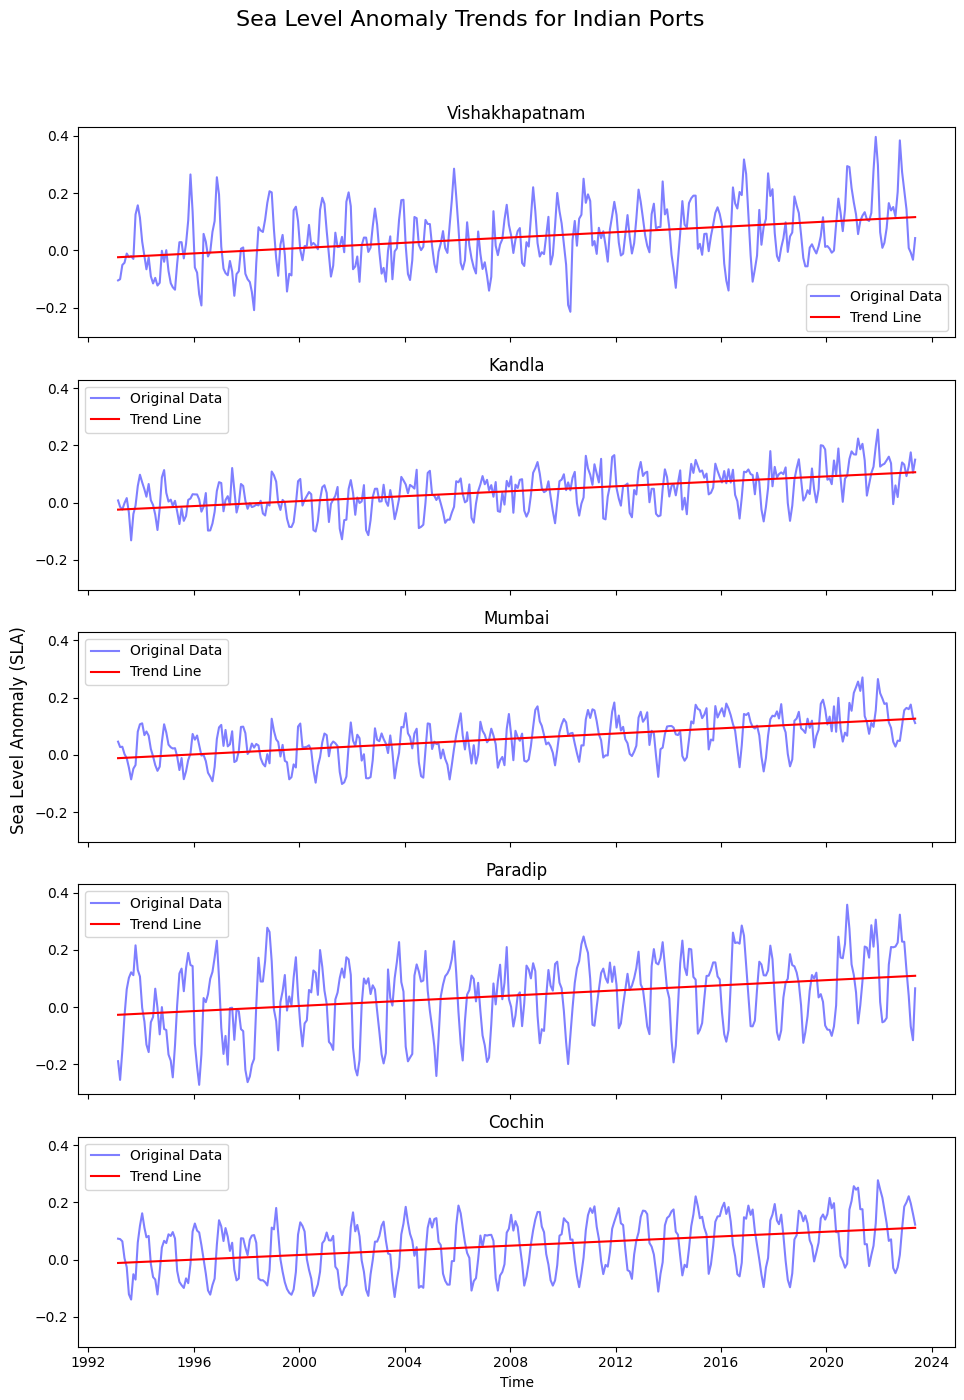

In [ ]:
# Set up the figure and axes for subplots
n_ports = len(trend_df)
fig, axes = plt.subplots(n_ports, 1, figsize=(10, 15), sharex=True, sharey = True)

# Loop through each port to plot the time series and regression line
for i, port in enumerate(trend_df['Port']):
    ax = axes[i]

    # Plot the time series data
    ax.plot(data.index, data[port], label='Original Data', color='blue', alpha=0.5)

    # Predict the regression line
    X = data[['time']]  # Time variable
    y_pred = trend_df.loc[i, 'intercept'] + trend_df.loc[i, 'slope'] * X

    # Plot the regression line
    ax.plot(data.index, y_pred, label='Trend Line', color='red')

    # Set titles and labels
    ax.set_title(f"{port}")
    ax.legend()

# Set common x-axis label
plt.xlabel("Time")
fig.text(0.04, 0.5, 'Sea Level Anomaly (SLA)', va='center', rotation='vertical', fontsize=12)
fig.suptitle("Sea Level Anomaly Trends for Indian Ports", fontsize=16)

# Adjust spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Leave space for the main title and y-label

# Adjust spacing between subplots
plt.show()